In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install catboost
!pip install xgboost

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


# **Explore the data**

In [3]:
data = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


<AxesSubplot:ylabel='Frequency'>

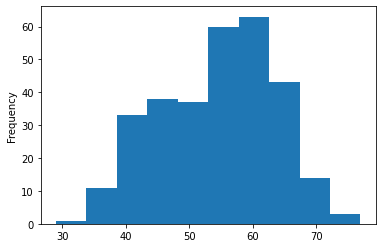

In [5]:
data["age"].plot(kind = "hist")

In [6]:
# corr_matrix = data.corr().T

# from pandas.plotting import scatter_matrix

# scatter_matrix(data)
data.corr().T

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


# **Set features and lables**

In [7]:
# target and feature data
y = data["output"].copy()
X = data.copy()
del X["output"]
# del X["fbs"]
# del X["chol"]
X

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


# **Train, test, split and assign classifier**

In [8]:
# Train test and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 32)

In [9]:
# clf = DecisionTreeClassifier(max_leaf_nodes = 5, random_state = 80) = 85%
clf = CatBoostClassifier(verbose=0, n_estimators=40)
clf.fit(X_train, y_train)

# **Predictions**

In [10]:
predictions = clf.predict(X_test)

In [11]:
actuals = np.ceil(list(y_test))

for prediction,actual in list(zip(predictions, actuals))[:10]:
    print("Prediction:", int(prediction), "Actual:", int(actual))

Prediction: 0 Actual: 1
Prediction: 0 Actual: 0
Prediction: 1 Actual: 1
Prediction: 1 Actual: 1
Prediction: 1 Actual: 1
Prediction: 1 Actual: 1
Prediction: 0 Actual: 0
Prediction: 0 Actual: 0
Prediction: 1 Actual: 1
Prediction: 1 Actual: 1


# **Confusion matrix**

Predicted,0,1
Actual,,
0.0,44,8
1.0,7,63


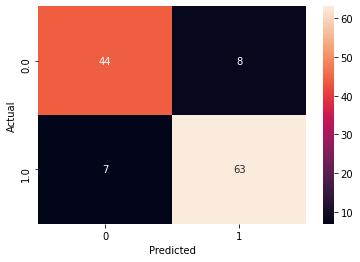

In [12]:
import seaborn as sn

confusion_matrix = pd.crosstab(actuals, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

confusion_matrix

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(actuals, predictions)
confusion_matrix

array([[44,  8],
       [ 7, 63]])

In [14]:
# Get confusion matrix metrics
true_positives = int(confusion_matrix[:1,:1])
true_negatives = int(confusion_matrix[-1:, -1:])
false_positives = int(confusion_matrix[:1,-1:])
false_negatives = int(confusion_matrix[-1:, :-1])

In [15]:
# Sensitivity
sensitivity = round(true_positives / (true_positives + false_negatives), 2)
sensitivity

0.86

In [16]:
# Specificity
specificity = round(true_negatives / (true_negatives + false_positives), 2)
specificity

0.89

In [17]:
# Precision
precision = round(true_positives / (true_positives + false_positives),2)
precision

0.85

# **Accuracy : 88%**
# **F1 Score : 87%**

In [18]:
# Accuracy
round(accuracy_score(predictions, y_test), 2)

0.88

In [19]:
# F1 score
round(2*(specificity * precision) / (specificity + precision), 2)

0.87